In [2]:
import matplotlib.pyplot as plt
import numpy as np
import rawpy
import cv2
import imageio
import sklearn.preprocessing

test = np.fromfile('flat_test_4_Depth.raw', dtype=np.int16, count=- 1, sep='')

test = np.reshape(test, (int(480/2), int(848/2)))

low_max = 10000
for i in range(0, 240):
    temp = np.max(test[i, 0:])
    if temp < low_max:
        low_max = temp
        loc = i
print(low_max, loc)
    
# new_test = np.zeros(np.shape(test))
# for i in range(0, 240):
#     diff = np.max(test[i, 0:])-low_max
#     plt.plot(test[i, 0:]-diff)
#     new_test[i, 0:] = test[i, 0:]-diff
plt.figure(figsize=(10,10))
norm = np.zeros(np.shape(test))
lowest = test[loc, 0:]
for i in range(0, 240):
    diff = np.max(test[i, 0:])-low_max
    norm[i, 0:] = test[i, 0:] - diff
    plt.plot(norm[i, 0:])
    
var_col = []
mean_col = []
for i in range(0, 424):
    var_col.append(np.var(norm[0:, i]))
    mean_col.append(np.mean(norm[0:, i]))
plt.figure()
plt.plot(mean_col[20:])
plt.figure()
plt.plot(var_col[20:])

var_row = []
mean_row = []
for i in range(0, 240):
    var_row.append(np.var(norm[i, 20:]))
    mean_row.append(np.mean(norm[i, 20:]))
plt.figure()
plt.plot(mean_row)
plt.figure()
plt.plot(var_row)

FileNotFoundError: [Errno 2] No such file or directory: 'flat_test_4_Depth.raw'

55967.13


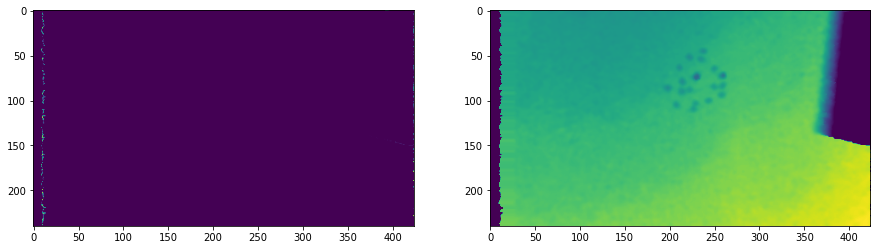

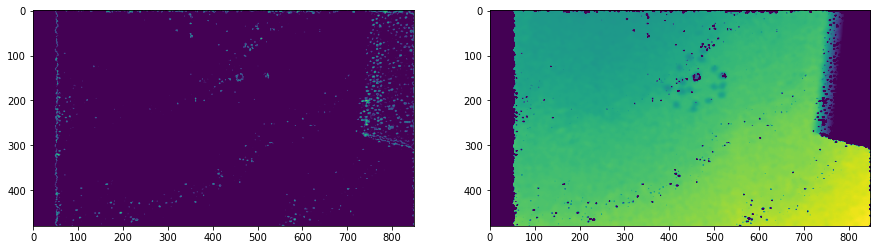

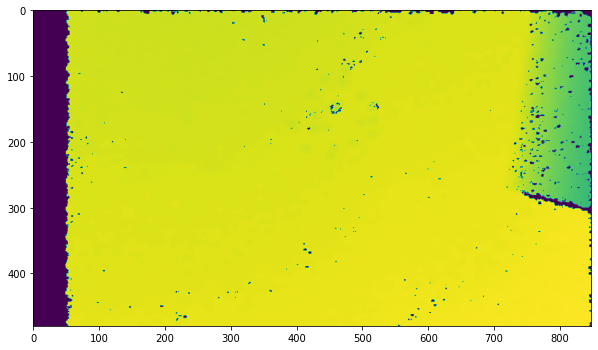

In [8]:
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import imageio
import time

num_images = 50

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.any, 848, 480, rs.format.z16, 30)
pipeline.start(config)

#Setting up filters
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 2)

spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
spatial.set_option(rs.option.holes_fill, 2)


storage = np.zeros((240,424, num_images))
sum_frame = np.zeros((240, 424))
#mean_frame = np.zeros((848, 480))
#var_frame = np.zeros((848, 480))


for i in range(0, num_images):
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    
    #filtering
    decimated_depth = decimation.process(depth_frame)
    filtered_depth = spatial.process(decimated_depth)
    
    
    depth_image = np.asanyarray(filtered_depth.get_data())
    storage[0:, 0:, i] = depth_image
    sum_frame = sum_frame+depth_image
    time.sleep(0.001)
    
mean_frame = sum_frame/num_images
var_frame = np.var(storage, axis=2)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(var_frame, vmin = 10)

plt.subplot(2, 2, 2)
plt.imshow(mean_frame, vmin = 400)


print(np.max(var_frame))

storage = np.zeros((480,848, num_images))
sum_frame = np.zeros((480,848))


for i in range(0, num_images):
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    depth_image = np.asanyarray(depth_frame.get_data())
    storage[0:, 0:, i] = depth_image
    sum_frame = sum_frame+depth_image
    time.sleep(0.001)
    
    

pipeline.stop()


mean_frame = sum_frame/num_images
var_frame = np.var(storage, axis=2)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(var_frame, vmin = 10)

plt.subplot(2, 2, 2)
plt.imshow(mean_frame, vmin = 400)

plt.figure(figsize=(10,10))
plt.imshow(depth_image)

In [2]:
def take_picture_filtered(d_mag, spatial_mag, s_alpha, s_delta, hole_fill):
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.any, 640, 480, rs.format.z16, 30)
    pipeline.start(config)
    time.sleep(0.001)
    #Setting up filters
    decimation = rs.decimation_filter()
    decimation.set_option(rs.option.filter_magnitude, d_mag)

    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, spatial_mag)
    spatial.set_option(rs.option.filter_smooth_alpha, s_alpha)
    spatial.set_option(rs.option.filter_smooth_delta, s_delta)
    spatial.set_option(rs.option.holes_fill, hole_fill)
    
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    
    #filtering
    decimated_depth = decimation.process(depth_frame)
    filtered_depth = spatial.process(decimated_depth)
    
    depth_image = np.asanyarray(filtered_depth.get_data())
    pipeline.stop()
    return depth_image

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


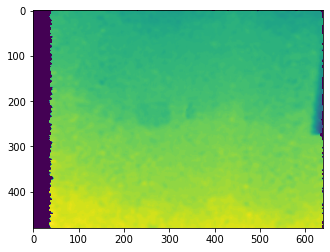

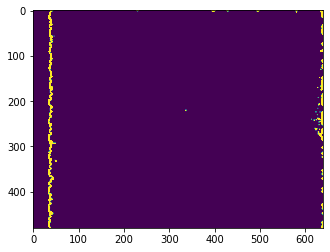

In [55]:
import skimage.filters
import skimage.exposure
import cv2


depth_image = take_picture_filtered(1, 3, 1, 50, 2)

grad_depth = skimage.filters.laplace(depth_image, ksize=3)
contrast_depth = skimage.exposure.equalize_adapthist(grad_depth, kernel_size = 3, nbins=256)


plt.figure()
plt.imshow(depth_image, vmin= 400, vmax=np.max(depth_image))


plt.figure()
plt.imshow(contrast_depth, vmax = np.max(contrast_depth)*0.01)

depth2 = depth_image.copy()
_,contours,_ = cv2.findContours(depth2.astype('uint16'), 1, 2)

cv2.drawContours(depth2, contours, -1, (0,255,0), 3)

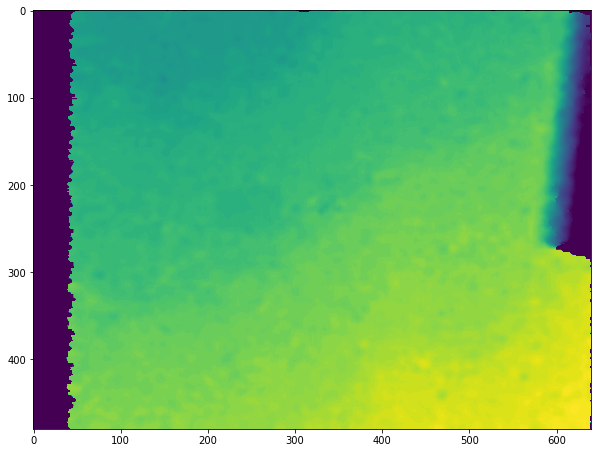

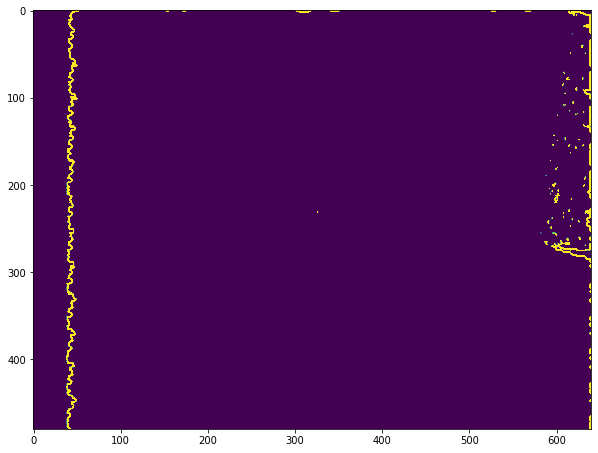

In [38]:
depth_image = take_picture_filtered(1, 5, 1, 1, 1)

grad_depth = skimage.filters.laplace(depth_image, ksize=3)
contrast_depth = skimage.exposure.equalize_adapthist(grad_depth, kernel_size = 3, nbins=256)


plt.figure(figsize=(10,10))
plt.imshow(depth_image, vmin = 400)


plt.figure(figsize=(10,10))
plt.imshow(contrast_depth, vmax = np.max(contrast_depth)*0.01)

C:\Users\zacha\AppData\Local\Temp/ipykernel_5072/1772579939.py:33: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  depth_image = skimage.feature.peak_local_max(depth_image, min_distance=15, exclude_border=True, indices=False)


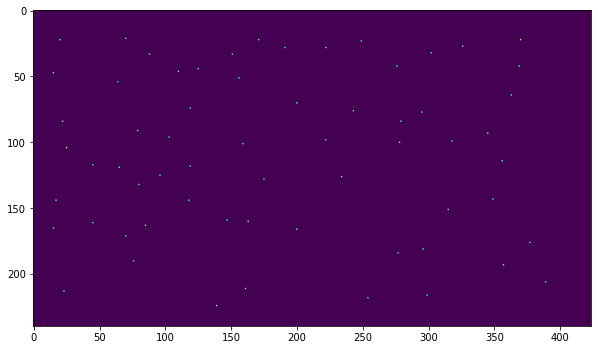

In [25]:
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters

num_images = 50

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.any, 848, 480, rs.format.z16, 30)
pipeline.start(config)

#Setting up filters
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 2)

spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
spatial.set_option(rs.option.holes_fill, 2)

frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
    
#filtering
decimated_depth = decimation.process(depth_frame)
filtered_depth = spatial.process(decimated_depth)
    
pipeline.stop()
depth_image = np.asanyarray(filtered_depth.get_data())

depth_image = skimage.feature.peak_local_max(depth_image, min_distance=15, exclude_border=True, indices=False)

plt.figure(figsize=(10,10))
plt.imshow(depth_image)